In [1]:
from ift6758.data import get_wandb_data
import wandb
import ift6758.visualizations.debugging_tool as debugging_tool
import ift6758.visualizations.baseline_models_figures as baseline_models_figures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib
import numpy as np

LOG = False

In [ ]:
artifact_name = "train_val_feature_eng_1"
get_wandb_data.download_artifact(artifact_name=artifact_name, artifact_version="v5")
df = get_wandb_data.load_all_files_from_artifact(artifact_name=artifact_name)
df

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb:   4 of 4 files downloaded.  


Artifact downloaded to: ../ift6758/data/wandb_artifacts//train_val_feature_eng_1


,season,game_id,event_id,angle_from_net,is_goal,empty_net,distance_from_net
0,20162017,2016020001,8,22.619865,0,0,13.000000
1,20162017,2016020001,11,77.005383,0,0,13.341664
2,20162017,2016020001,15,29.931512,0,0,76.157731
3,20162017,2016020001,16,14.995079,0,0,57.974132
4,20162017,2016020001,24,26.980231,0,0,61.717096
...,...,...,...,...,...,...,...
305792,20192020,2019021082,773,62.447188,0,0,25.942244
305793,20192020,2019021082,774,71.113913,0,0,40.162171
305794,20192020,2019021082,537,45.000000,0,0,14.142136
305795,20192020,2019021082,777,41.185925,0,0,10.630146


# q1

In [4]:
# Initialize and train the logistic regression model
def train_evaluate_logistic_regression_model(X_train, y_train, X_val, y_val, model_name):
    model = LogisticRegression()
    model.fit(X_train, y_train)

    base_path = "../ift6758/models"
    model_path = f"{base_path}/{model_name}.pkl"
    joblib.dump(model, model_path)

    # Make predictions on the test set
    y_pred_discrete = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)

    # Calculate and print the accuracy
    accuracy = accuracy_score(y_val, y_pred_discrete)
    print(f'Accuracy: {accuracy}')

    return y_pred_discrete, y_pred_proba, model_path


notice accuracy high but model only predicts the events are non-goals because there are more non-goal events than goals events
so the model hasn't learnt anything

In [5]:
debugging_tool.display_game_id("2019020873")

id 2019020873
date 2020-02-11
Venue Location:  Dallas
Home Team:  Stars
Away Team: Hurricanes



Text(value='0', description='Event no:')

In [6]:
def log_model_wandb(y_true, y_pred, model_path, features):
    with wandb.init(name="feature_eng1_logistic_regression_logs", project="IFT6758-2024-B05", job_type="model-evaluation") as run:

        run.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                                                                y_true=y_true.flatten().tolist(),
                                                                preds=y_pred.flatten().tolist(),
                                                                class_names=["Not Goal", "Goal"])})


        run.config.update({
            "model_type": "LogisticRegression",
            "test_size": 0.2,
            "random_state": 42,
            "features": features
        })
        run.log({"accuracy": accuracy_score(y_true, y_pred)})
        run.log({"precision:": precision_score(y_true, y_pred)})
        run.log({"recall": recall_score(y_true, y_pred)})
        run.log({"f1_score": f1_score(y_true, y_pred)})

        run.log_model(model_path, name=model_path.split("/")[-1].split(".")[0])

c:\Users\dre\miniconda3\envs\ift-6758-lab-venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.9062132112491825


c:\Users\dre\miniconda3\envs\ift-6758-lab-venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


accuracy,▁
f1_score,▁
precision:,▁
recall,▁
accuracy,0.90621
f1_score,0
precision:,0
recall,0


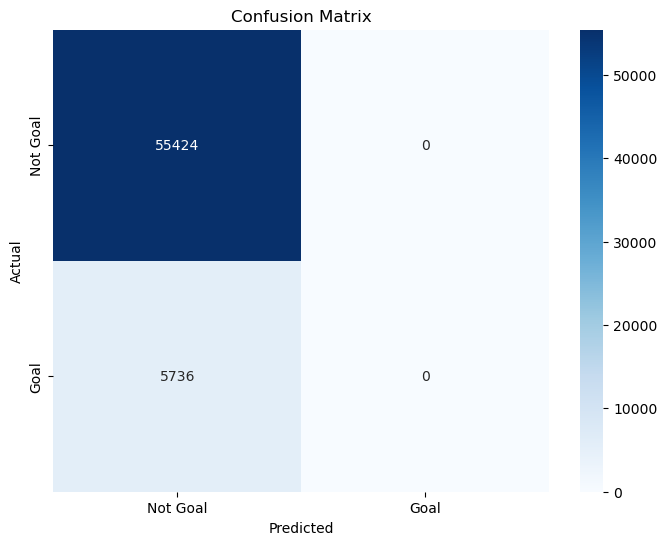

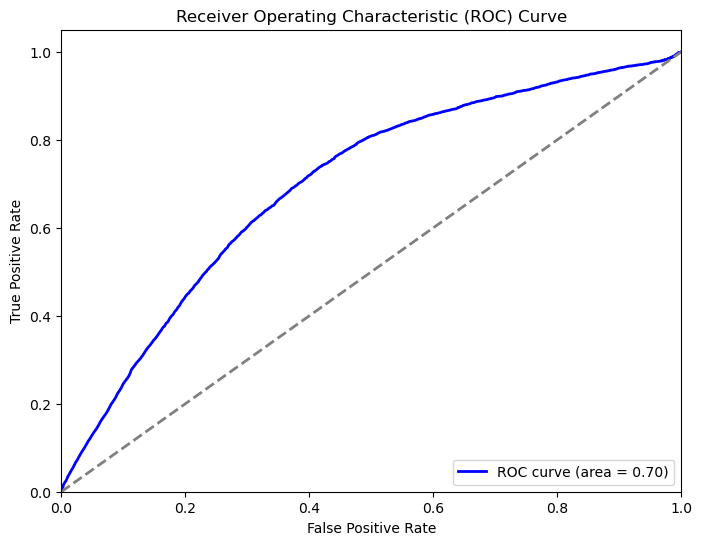

c:\users\dre\documents\agrosante_udem\cours\data_science\nhl project\ift-6758-project\ift6758\visualizations\baseline_models_figures.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  goal_rate_by_percentile = df_percentiles.groupby('Percentile')['Actual'].apply(lambda x: x.sum() / len(x))
c:\users\dre\documents\agrosante_udem\cours\data_science\nhl project\ift-6758-project\ift6758\visualizations\baseline_models_figures.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  goal_rate_by_percentile = df_percentiles.groupby('Percentile')['Actual'].mean()


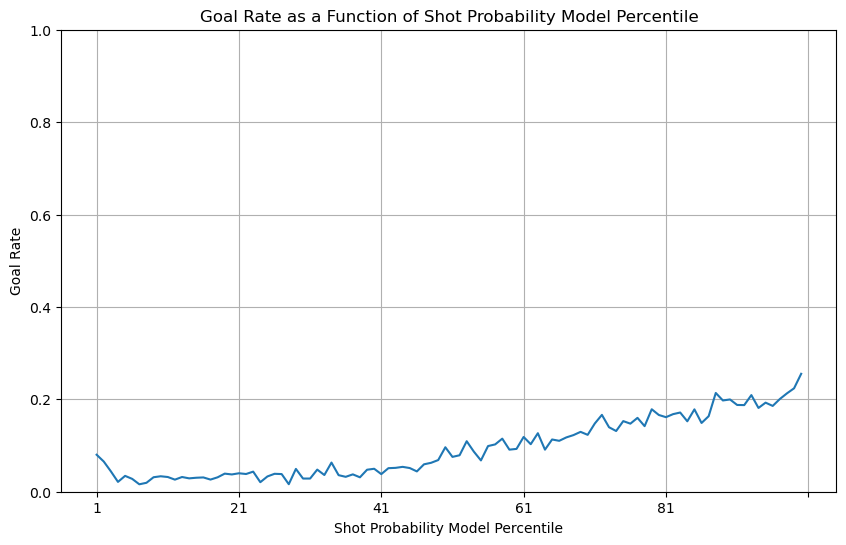

c:\users\dre\documents\agrosante_udem\cours\data_science\nhl project\ift-6758-project\ift6758\visualizations\baseline_models_figures.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cumulative_goals = df_percentiles.groupby('Percentile')['Actual'].sum().cumsum()


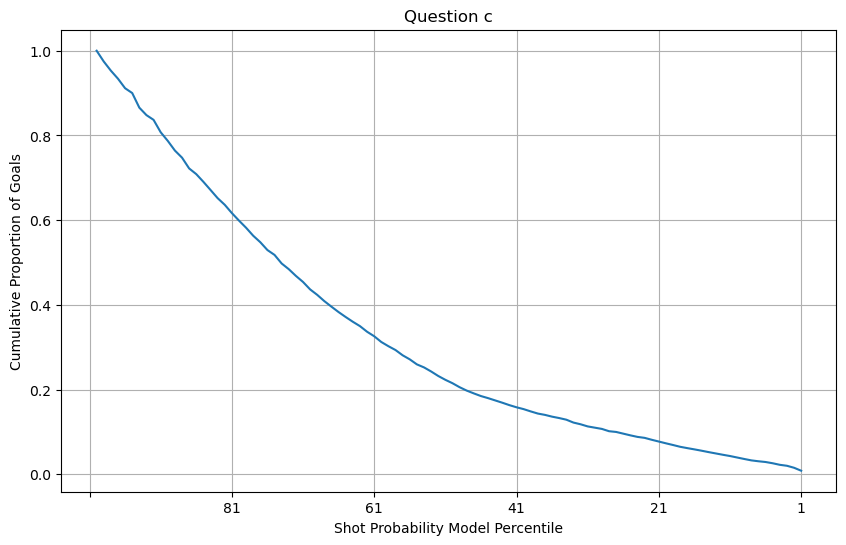

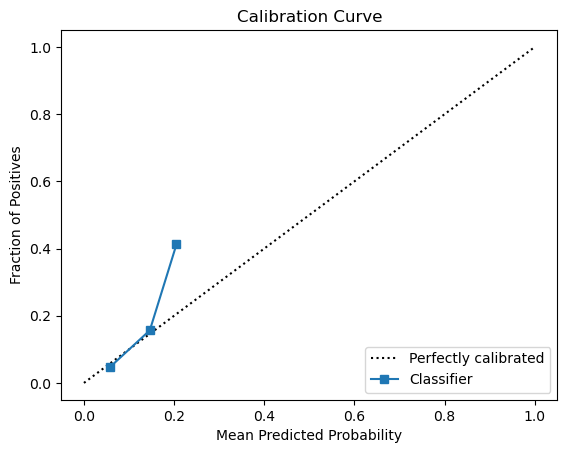

In [ ]:
# Define features and target variable
X = df['distance'].to_numpy().reshape(-1, 1)
y = df['is_goal'].to_numpy().reshape(-1, 1)

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred_distance_discrete, y_pred_distance_proba, model_distance_path = train_evaluate_logistic_regression_model(X_train, y_train, X_val, y_val, "logistic_regression_distance")
log_model_wandb(y_val, y_pred_distance_discrete, model_distance_path, ['distance'])

baseline_models_figures.plot_figures(y_pred_distance_proba, y_pred_distance_discrete, y_val)


c:\Users\dre\miniconda3\envs\ift-6758-lab-venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.9062132112491825


c:\Users\dre\miniconda3\envs\ift-6758-lab-venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


accuracy,▁
f1_score,▁
precision:,▁
recall,▁
accuracy,0.90621
f1_score,0
precision:,0
recall,0


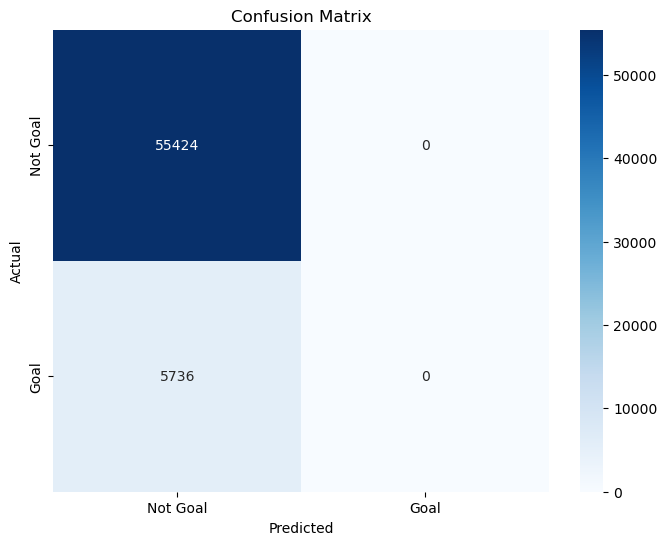

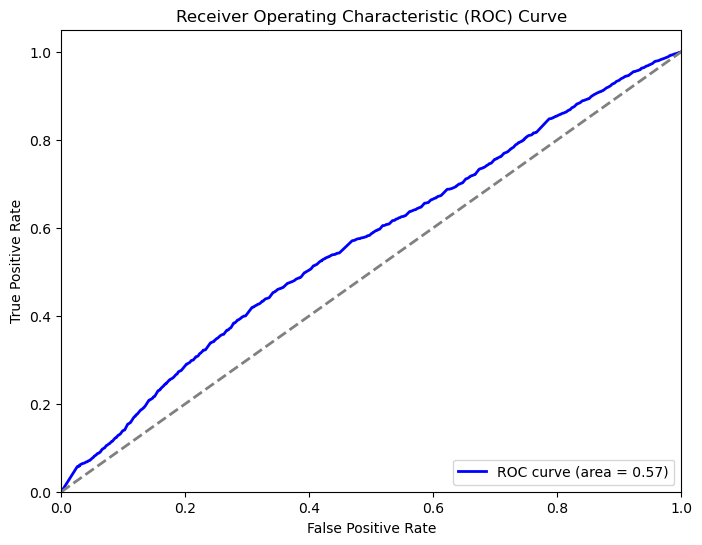

c:\users\dre\documents\agrosante_udem\cours\data_science\nhl project\ift-6758-project\ift6758\visualizations\baseline_models_figures.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  goal_rate_by_percentile = df_percentiles.groupby('Percentile')['Actual'].apply(lambda x: x.sum() / len(x))
c:\users\dre\documents\agrosante_udem\cours\data_science\nhl project\ift-6758-project\ift6758\visualizations\baseline_models_figures.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  goal_rate_by_percentile = df_percentiles.groupby('Percentile')['Actual'].mean()


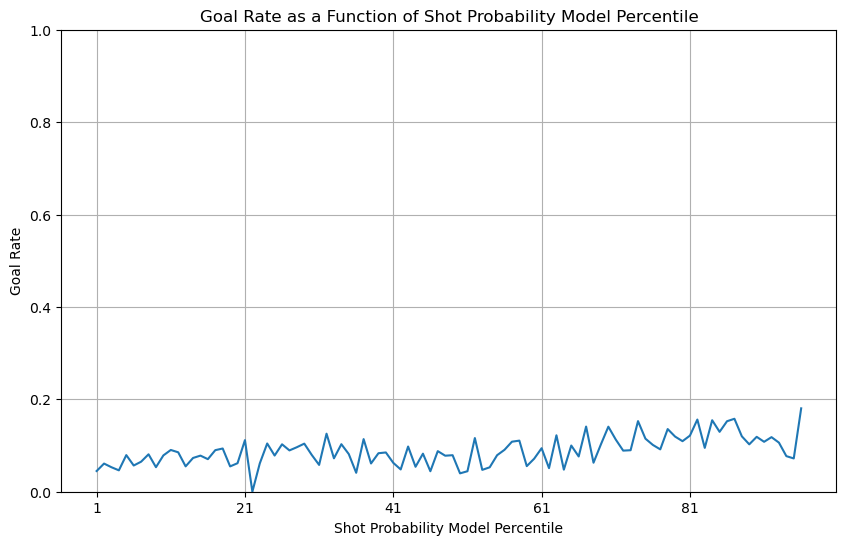

c:\users\dre\documents\agrosante_udem\cours\data_science\nhl project\ift-6758-project\ift6758\visualizations\baseline_models_figures.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cumulative_goals = df_percentiles.groupby('Percentile')['Actual'].sum().cumsum()


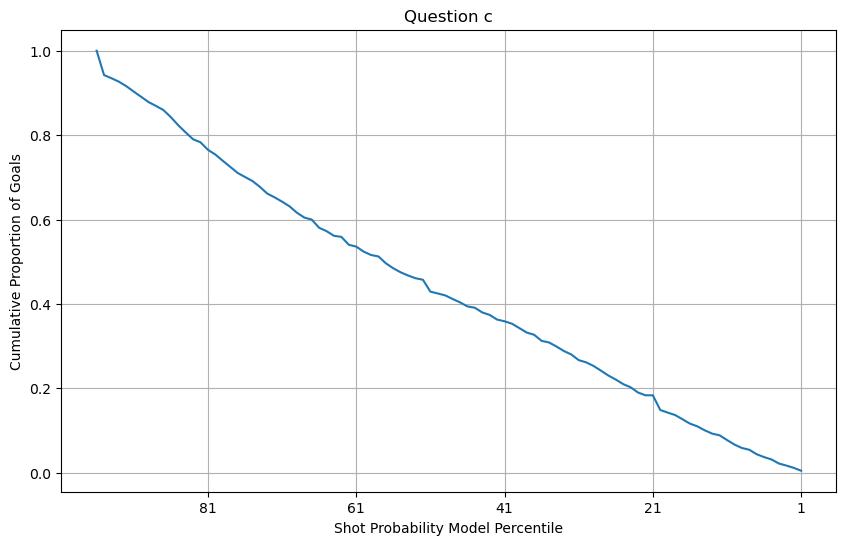

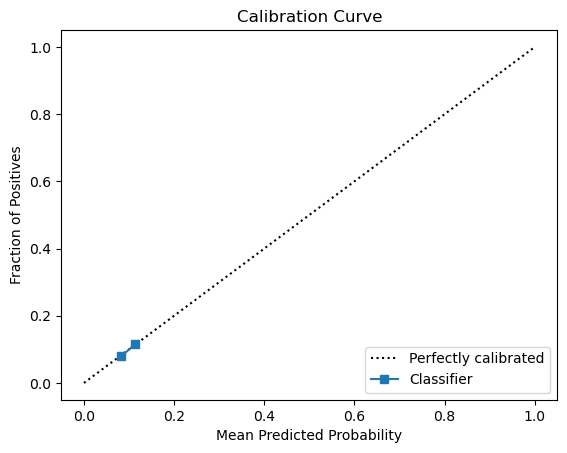

In [ ]:
# Define features and target variable
X_angle = df['angle'].to_numpy().reshape(-1, 1)
y = df['is_goal'].to_numpy().reshape(-1, 1)

# Split the data into training and testing sets
X_train_angle, X_val_angle, y_train, y_val = train_test_split(X_angle, y, test_size=0.2, random_state=42)

# Train the logistic regression model
y_pred_discrete_angle, y_pred_proba_angle, model_angle = train_evaluate_logistic_regression_model(X_train_angle, y_train, X_val_angle, y_val, "logistic_regression_angle")
log_model_wandb(y_val, y_pred_discrete_angle, model_angle, ["angle"])

# Produce figures
baseline_models_figures.plot_figures(y_pred_proba_angle, y_pred_discrete_angle, y_val)


In [11]:
y_pred_distance_discrete, y_pred_distance_proba, model_distance_path = train_evaluate_logistic_regression_model(X_train, y_train, X_val, y_val, "logistic_regression_distance")
log_model_wandb(y_val, y_pred_distance_discrete, model_distance_path, ['distance'])

c:\Users\dre\miniconda3\envs\ift-6758-lab-venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.9062132112491825


c:\Users\dre\miniconda3\envs\ift-6758-lab-venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


accuracy,▁
f1_score,▁
precision:,▁
recall,▁
accuracy,0.90621
f1_score,0
precision:,0
recall,0


c:\Users\dre\miniconda3\envs\ift-6758-lab-venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.9062132112491825


c:\Users\dre\miniconda3\envs\ift-6758-lab-venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


accuracy,▁
f1_score,▁
precision:,▁
recall,▁
accuracy,0.90621
f1_score,0
precision:,0
recall,0


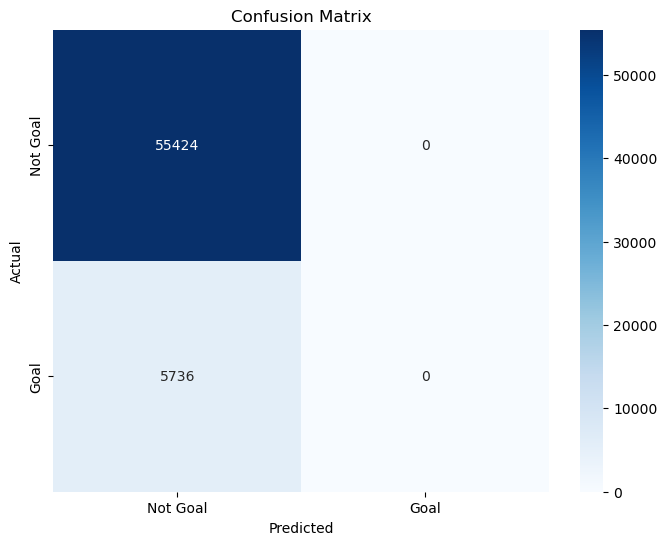

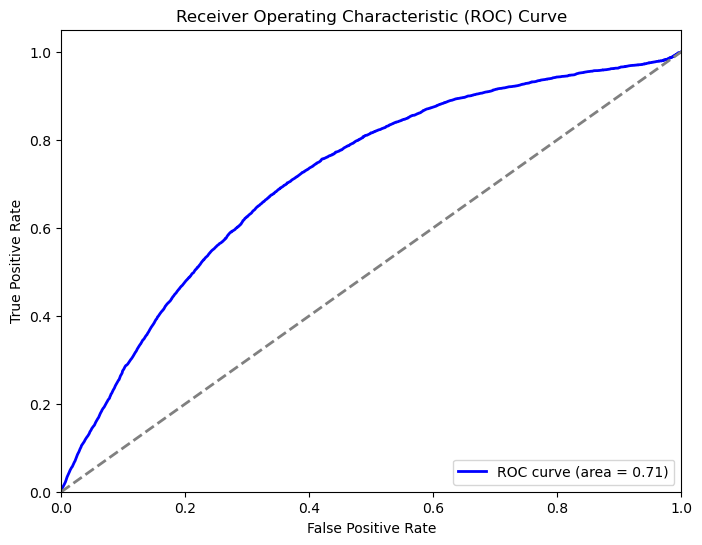

c:\users\dre\documents\agrosante_udem\cours\data_science\nhl project\ift-6758-project\ift6758\visualizations\baseline_models_figures.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  goal_rate_by_percentile = df_percentiles.groupby('Percentile')['Actual'].apply(lambda x: x.sum() / len(x))
c:\users\dre\documents\agrosante_udem\cours\data_science\nhl project\ift-6758-project\ift6758\visualizations\baseline_models_figures.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  goal_rate_by_percentile = df_percentiles.groupby('Percentile')['Actual'].mean()


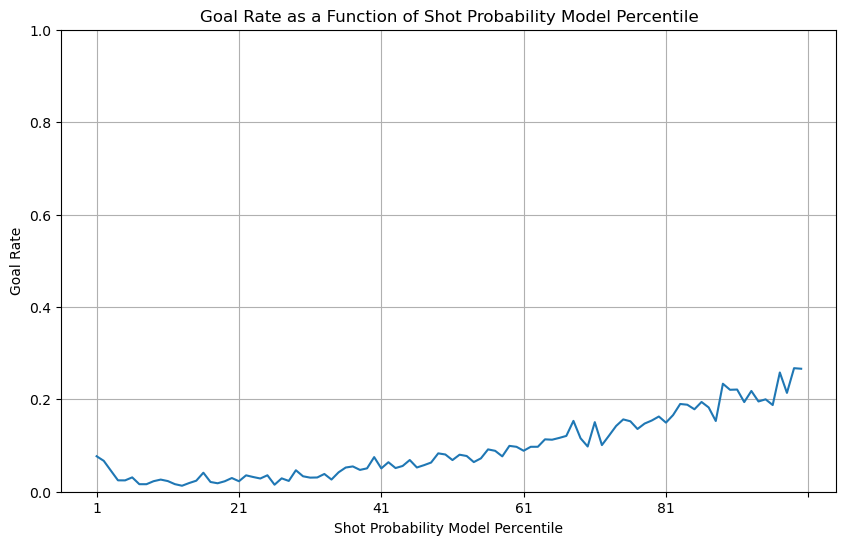

c:\users\dre\documents\agrosante_udem\cours\data_science\nhl project\ift-6758-project\ift6758\visualizations\baseline_models_figures.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cumulative_goals = df_percentiles.groupby('Percentile')['Actual'].sum().cumsum()


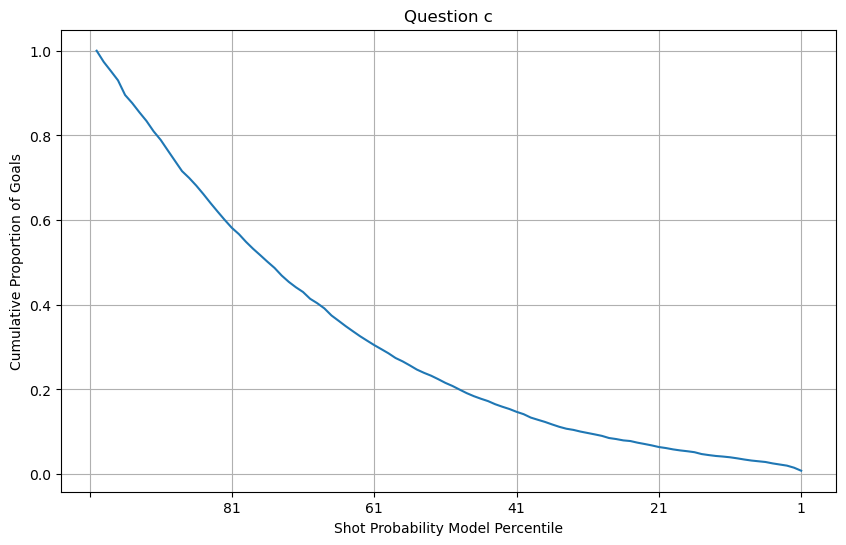

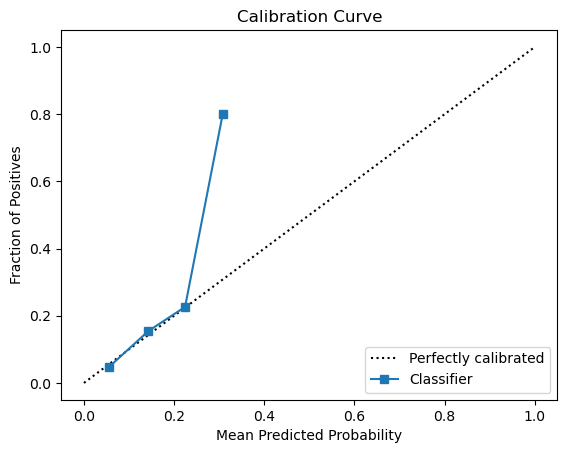

In [ ]:
X_distance_angle = df[['distance', 'angle']].to_numpy()
y = df['is_goal'].to_numpy().reshape(-1, 1)
X_train_distance_angle, X_val_distance_angle, y_train, y_val = train_test_split(X_distance_angle, y, test_size=0.2, random_state=42)
y_pred_discrete_distance_angle, y_pred_proba_distance_angle, model_distance_angle = train_evaluate_logistic_regression_model(X_train_distance_angle, y_train, X_val_distance_angle, y_val, "logistic_regression_distance_angle")
log_model_wandb(y_val, y_pred_discrete_distance_angle, model_distance_angle, ["distance", "angle"])
baseline_models_figures.plot_figures(y_pred_proba_distance_angle, y_pred_discrete_distance_angle, y_val)

In [13]:
y_pred_proba_random = np.random.uniform(0, 1, size=y_val.shape)
y_pred_discrete_random = np.round(y_pred_proba_random)
y_pred_proba_random = np.hstack((1 - y_pred_proba_random, y_pred_proba_random)) # create probabilities for both classes to mimic the output of the logistic regression model and be able to use the same plotting function

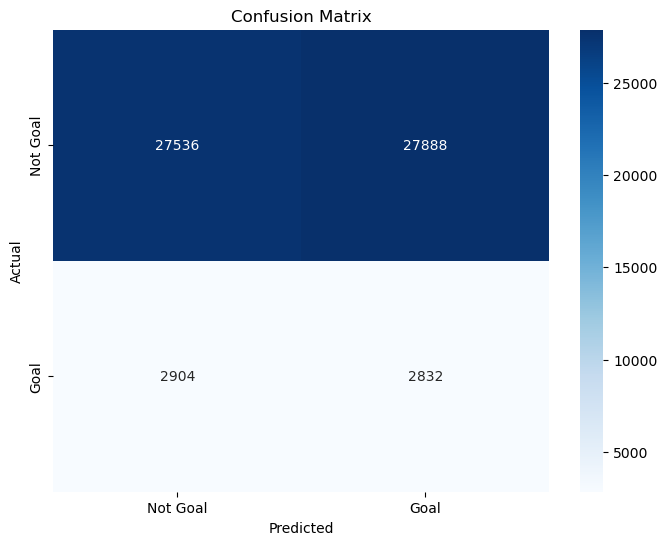

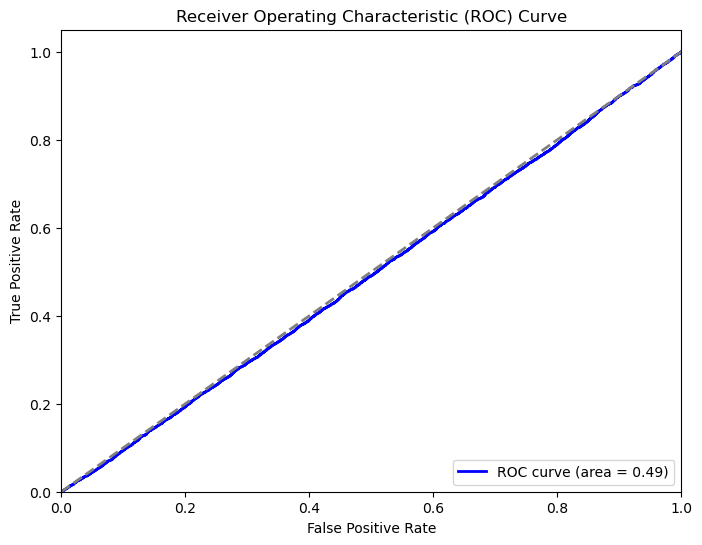

c:\users\dre\documents\agrosante_udem\cours\data_science\nhl project\ift-6758-project\ift6758\visualizations\baseline_models_figures.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  goal_rate_by_percentile = df_percentiles.groupby('Percentile')['Actual'].apply(lambda x: x.sum() / len(x))
c:\users\dre\documents\agrosante_udem\cours\data_science\nhl project\ift-6758-project\ift6758\visualizations\baseline_models_figures.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  goal_rate_by_percentile = df_percentiles.groupby('Percentile')['Actual'].mean()


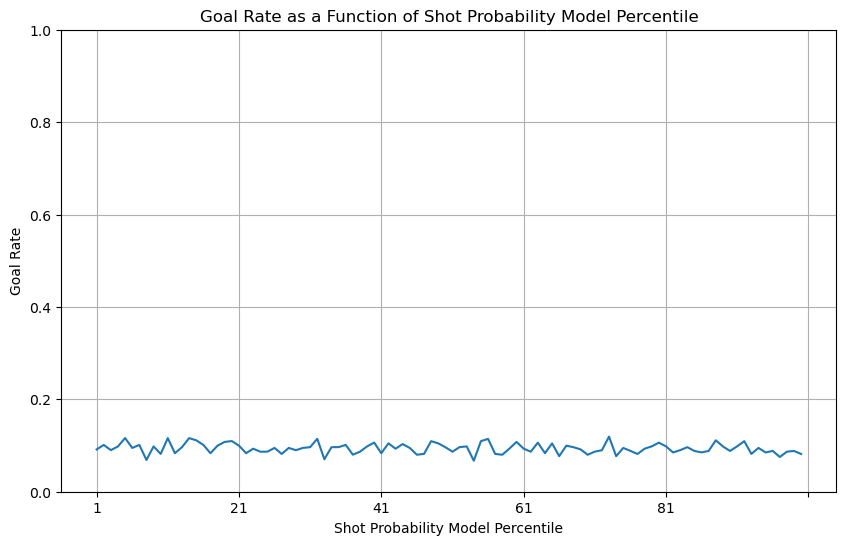

c:\users\dre\documents\agrosante_udem\cours\data_science\nhl project\ift-6758-project\ift6758\visualizations\baseline_models_figures.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cumulative_goals = df_percentiles.groupby('Percentile')['Actual'].sum().cumsum()


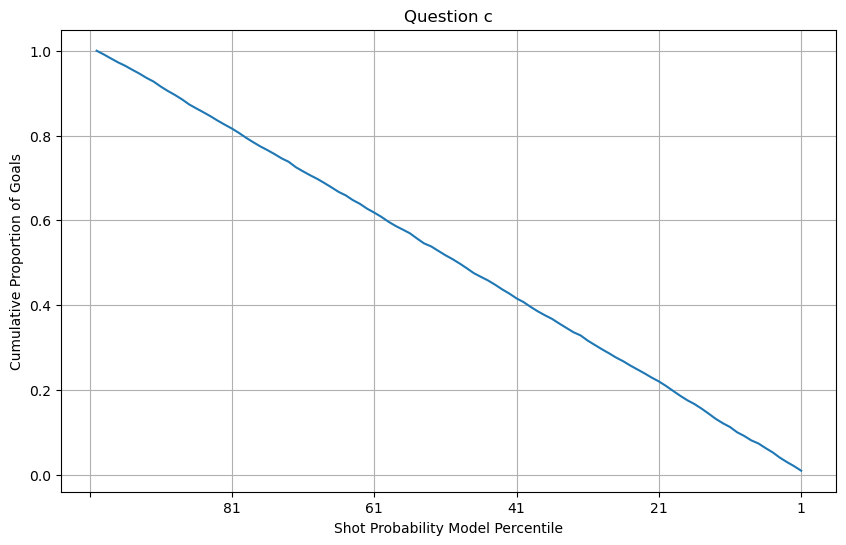

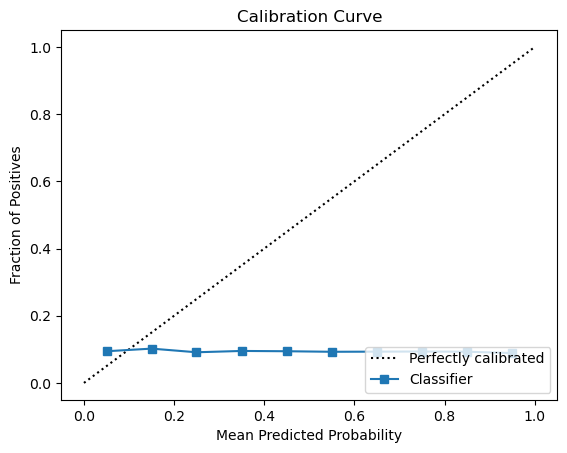

In [14]:
baseline_models_figures.plot_figures(y_pred_proba_random, y_pred_discrete_random, y_val)